This notebook imports data that were scraped from BoxOfficeMojo in previous notebooks. The data include:

 - Movie Title, Studio, Opening, Budget, Earliest Release Date, MPAA Rating, Runtime, Genres, Domestic Gross, International Gross

Workflow:
Package into a pandas DataFrame, 





In [176]:
import requests
import pickle
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

### Read in the data, create a DataFrame

In [177]:
# Read in the list of dictionaries with movie data
with open('movies_data_raw.pickle','rb') as read_file:
    movies_raw = pickle.load(read_file)

In [178]:
# convert to a data frame
movies_df = pd.DataFrame(movies_raw)
movies_df

,Title,Studio,Opening,Budget,Release,Rating,Runtime,Genre,Domestic,International
0,Toy Story 4,Walt Disney Studios Motion Pictures,"$120,908,065","$200,000,000","June 20, 2019",G,1 hr 40 min,"[Adventure, Animation, Comedy, Family, Fantasy]","$434,038,008","$639,356,585"
1,The Lion King,Walt Disney Studios Motion Pictures,"$1,586,753","$45,000,000","June 15, 1994",G,1 hr 28 min,"[Adventure, Animation, Drama, Family, Musical]","$422,783,777","$545,728,028"
2,Toy Story 3,Walt Disney Studios Motion Pictures,"$110,307,189","$200,000,000","June 16, 2010",na,1 hr 43 min,"[Adventure, Animation, Comedy, Family, Fantasy]","$415,004,880","$651,964,823"
3,Finding Nemo,Walt Disney Studios Motion Pictures,"$70,251,710","$94,000,000","May 30, 2003",na,1 hr 40 min,"[Adventure, Animation, Comedy, Family]","$380,843,261","$559,506,933"
4,"Monsters, Inc.",Walt Disney Studios Motion Pictures,"$62,577,067","$115,000,000","November 2, 2001",G,1 hr 32 min,"[Adventure, Animation, Comedy, Family, Fantasy]","$289,916,256","$289,064,814"
...,...,...,...,...,...,...,...,...,...,...
3358,Three Days of the Condor,Paramount Pictures,na,na,"September 24, 1975",na,1 hr 57 min,"[Mystery, Thriller]","$27,476,252","$27,476,252"
3359,Friday,New Line Cinema,"$6,589,341","$3,500,000","April 28, 1995",R,1 hr 31 min,"[Comedy, Drama]","$27,467,564","$748,354"
3360,The Brothers,Screen Gems,"$10,302,846","$6,000,000","March 23, 2001",R,1 hr 46 min,"[Comedy, Drama]","$27,457,409","$500,782"
3361,Midsommar,A24,"$6,560,030","$9,000,000","July 3, 2019",R,2 hr 28 min,"[Drama, Horror, Mystery, Thriller]","$27,426,361","$20,476,738"


In [179]:
# Drop title and international earnings, which won't be used in later analyses
movies_df.drop(columns=['Title','International'], inplace=True, axis=1)

In [180]:
# Change 'na' to np.nan
movies_df.replace('na',np.nan, inplace=True)

In [181]:
# Get a report of 'na' fields by feature
movies_df.apply(lambda x: sum(x.isna()), axis=0)

Studio         7
Opening      251
Budget      1386
Release        2
Rating       859
Runtime        0
Genre          0
Domestic       0
dtype: int64

### Impute ratings

In [182]:
# Movies are sorted by MPAA rating
# That let's us impute missing values in the rating column
for index, row in movies_df.iterrows():
    if row['Rating'] in ['G','PG','PG-13','R']:
        current_rating = row['Rating']
    else:
        row['Rating'] = current_rating

### Drop rows with NA Budget and Opening

In [183]:
# Budget and Opening account for most NAs. Dropping these gets rid of rows with NA in other features as well.
movies_df.dropna(subset=['Budget','Opening'],axis=0,inplace=True)

In [184]:
# Check if any NAs remaining
movies_df.apply(lambda x: sum(x.isna()), axis=0)

Studio      0
Opening     0
Budget      0
Release     0
Rating      0
Runtime     0
Genre       0
Domestic    0
dtype: int64

In [185]:
movies_df.shape

(1935, 8)

### Convert Release Date to DateTime object

In [186]:
# Convert Release Date, drop the original
movies_df['Year'] = pd.to_datetime(movies_df['Release']).dt.year
movies_df['Month'] = pd.to_datetime(movies_df['Release']).dt.month
movies_df.drop(columns=['Release'], inplace=True, axis=1)

### Convert Runtime string to minutes integer

In [187]:
# Some runtimes list hours and minutes, some only list hours
# Use runtime_to_minutes to convert runtime string to an integer of total minutes

def runtime_to_minutes(row):
    """
    Split runtime string into hours and minutes (or just hours),
    convert values to integers, and return runtime as an integer of total minutes
    """
    time_list = row['Runtime'].split(' ')
    if len(time_list) == 2:
        tot_mins = int(time_list[0])*60
    else:
        tot_mins = int(time_list[0])*60 + int(time_list[2])
    return tot_mins

movies_df['Runtime'] = movies_df.apply(runtime_to_minutes, axis = 1)

### Convert currency to integer values

In [188]:
# Convert currency strings to integers so they can be used as a continuous features
def currency_to_int(row):
    """
    Convert currency string in columns 'Opening', 'Budget', 'Domestic' and 'International' to integers.
    In cases where scraping algorithm set undefined international earnings equal to domestic, 
    replace international earnings with 0.
    """
    opening = int(row['Opening'].replace('$','').replace(',',''))
    budget = int(row['Budget'].replace('$','').replace(',',''))
    domestic = int(row['Domestic'].replace('$','').replace(',',''))
    return opening, budget, domestic

movies_df[['Opening','Budget','Domestic']] = list(movies_df.apply(currency_to_int, axis = 1))

### Curate studios

In [189]:
# Get a list of studios that account for 90% of movies in the df
studio_counts = movies_df['Studio'].value_counts().reset_index()
top_studios = []
count = 0
i=0
while count < 0.9*len(movies_df):
    top_studios.append(studio_counts['index'].iloc[i])
    count+= studio_counts['Studio'].iloc[i]
    i+=1

# Replace studio name with "other" if not in the list of top_studios

def replace_studio(row):
    if row['Studio'] in top_studios:
        return row['Studio']
    else:
        return 'Other'

movies_df['Studio'] = movies_df.apply(replace_studio, axis=1)

In [190]:
movies_df['Studio'].value_counts()

Warner Bros.                           289
Universal Pictures                     259
Twentieth Century Fox                  234
Walt Disney Studios Motion Pictures    206
Paramount Pictures                     199
Sony Pictures Entertainment (SPE)      193
Other                                  178
Lionsgate                               79
New Line Cinema                         53
Screen Gems                             42
DreamWorks Distribution                 40
Metro-Goldwyn-Mayer (MGM)               33
Miramax                                 32
DreamWorks                              26
TriStar Pictures                        25
Focus Features                          24
Fox Searchlight Pictures                23
Name: Studio, dtype: int64

In [191]:
# Set dummy variables for studios
studio_dummies = pd.get_dummies(movies_df['Studio'])
movies_df = pd.concat([movies_df, studio_dummies], axis=1)
movies_df.drop(columns=['Studio'], inplace=True, axis=1)

In [192]:
# Set dummy variables for rating
rating_dummies = pd.get_dummies(movies_df['Rating'])
movies_df = pd.concat([movies_df, rating_dummies], axis=1)
movies_df.drop(columns=['Rating'], inplace=True, axis=1)

In [193]:
# Bin movies by length
def bin_length(row):
    if row['Runtime'] <=80:
        return 'short'
    elif (row['Runtime'] >80) & (row['Runtime'] <=110):
        return 'medium'
    elif (row['Runtime'] >110) & (row['Runtime'] <=140):
        return 'long'
    else:
        return 'xlong'

movies_df['Length'] = movies_df.apply(bin_length, axis=1)

# Set dummies
runtime_dummies = pd.get_dummies(movies_df['Length'])
movies_df = pd.concat([movies_df, runtime_dummies], axis=1)
movies_df.drop(columns=['Length'], inplace=True, axis=1)

In [194]:
# Set dummy variables for genre
genre_dummies = pd.get_dummies(movies_df['Genre'].apply(pd.Series).stack()).sum(level=0)
movies_df = pd.concat([movies_df, genre_dummies], axis=1)
movies_df.drop(columns=['Genre'], inplace=True, axis=1)

In [195]:
# Replace numberical month with abbreviation
num_index = [_ for _ in range(1,13)]
month_index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
movies_df['Month'] = movies_df['Month'].replace(num_index, month_index)

In [196]:
# Set dummy variables for month
month_dummies = pd.get_dummies(movies_df['Month'])
movies_df = pd.concat([movies_df, month_dummies], axis=1)
movies_df.drop(columns=['Month'], inplace=True, axis=1)

# Explore correlations

In [197]:
movies_df.shape

(1935, 63)

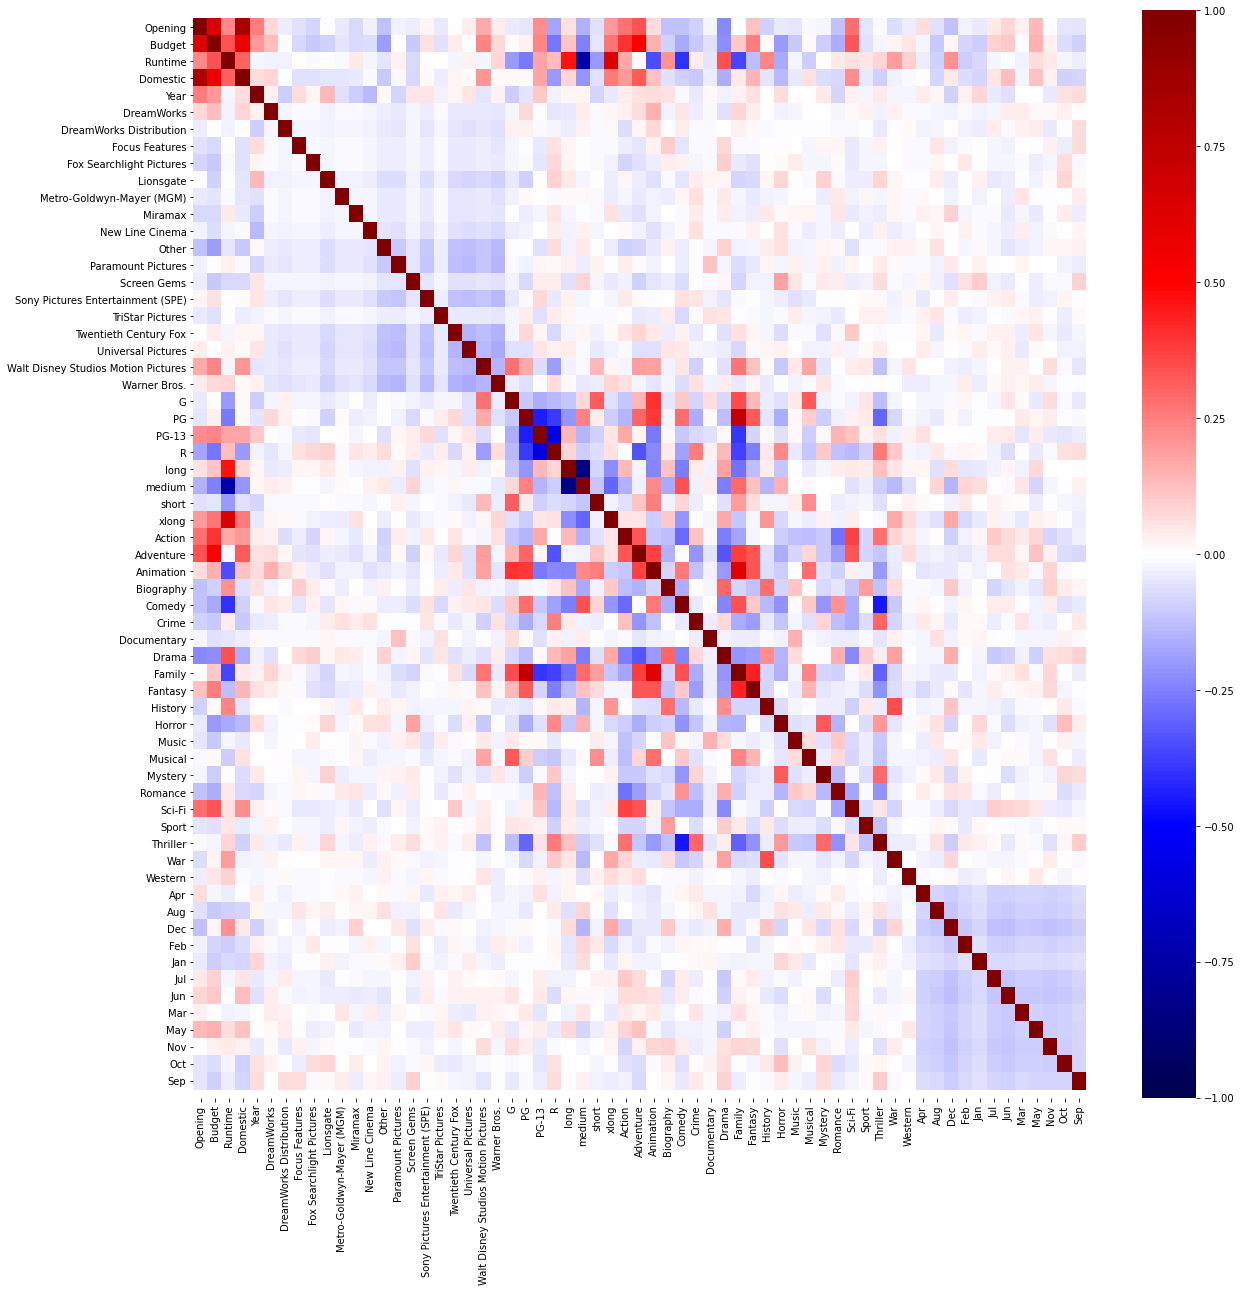

In [198]:
plt.figure(figsize=(20,20))
sns.heatmap(movies_df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)
plt.gca().set_ylim(len(movies_df.corr())+0.5, -0.5);

In [199]:
# Find the features that are most highly correlated with Domestic earnings
movies_corr = movies_df.corr()
mask = ((movies_corr['Domestic'] >= 0.5) | (movies_corr['Domestic'] <= -0.5))
movies_corr[mask]['Domestic']

Opening     0.831127
Budget      0.568783
Domestic    1.000000
Name: Domestic, dtype: float64

# Domestic ~ Opening + Budget

In [200]:
# Create a simple linear regression:
lr_simple = LinearRegression()

# Choose Opening and Budget as features
X = movies_df[['Opening', 'Budget']]

# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_simple.fit(X,y)

# Score
lr_simple.score(X,y)

0.6930510588376196

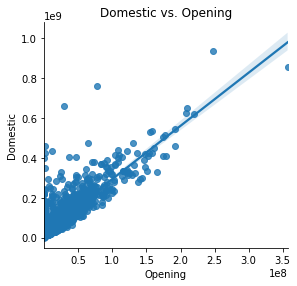

In [201]:
sns.lmplot(x='Opening', y='Domestic',\
           data=movies_df, fit_reg=True, height=4)
ax = plt.gca()
ax.set_title('Domestic vs. Opening');

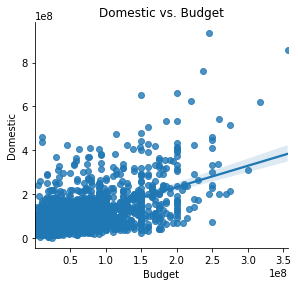

In [202]:
sns.lmplot(x='Budget', y='Domestic',\
           data=movies_df, fit_reg=True, height=4)
ax = plt.gca()
ax.set_title('Domestic vs. Budget');

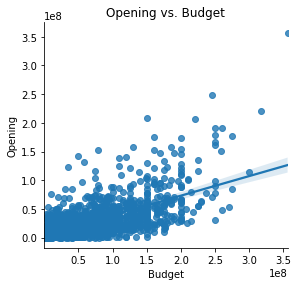

In [203]:
sns.lmplot(x='Budget', y='Opening',\
           data=movies_df, fit_reg=True, height=4)
ax = plt.gca()
ax.set_title('Opening vs. Budget');

# Domestic ~ Opening + Budget + Year

### sklearn

In [204]:
# Create a simple linear regression:
lr_OBY = LinearRegression()

# Choose Opening and Budget as features
X = movies_df[['Opening', 'Budget', 'Year']]

# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_OBY.fit(X,y)

# Score
lr_OBY.score(X,y)

0.7168362668767077

In [205]:
# Create a polynomial regression with budget**exp:
lr_OBY = LinearRegression()

# Choose Opening and Budget as features
X = movies_df[['Opening', 'Budget', 'Year']]
X['Budget_exp'] = X['Budget']**2
# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_OBY.fit(X,y)

# Score
lr_OBY.score(X,y)

<ipython-input-205-a5a985a961a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Budget_exp'] = X['Budget']**2


0.7169293816656153

In [206]:
X

,Opening,Budget,Year,Budget_exp
0,120908065,200000000,2019,40000000000000000
1,1586753,45000000,1994,2025000000000000
2,110307189,200000000,2010,40000000000000000
3,70251710,94000000,2003,8836000000000000
4,62577067,115000000,2001,13225000000000000
...,...,...,...,...
3353,14118444,11000000,2009,121000000000000
3359,6589341,3500000,1995,12250000000000
3360,10302846,6000000,2001,36000000000000
3361,6560030,9000000,2019,81000000000000


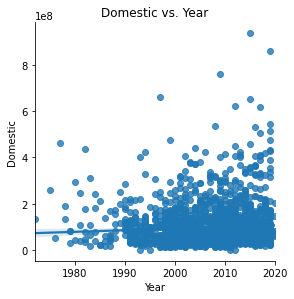

In [207]:
sns.lmplot(x='Year', y='Domestic',\
           data=movies_df, fit_reg=True, height=4)
ax = plt.gca()
ax.set_title('Domestic vs. Year');

### statsmodels

In [208]:
sm_OBY = sm.OLS(y, sm.add_constant(X))
fit_OBY = sm_OBY.fit()
fit_OBY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Domestic   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1452.
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:40:44   Log-Likelihood:                -37032.
No. Observations:                1935   AIC:                         7.407e+04
Df Residuals:                    1931   BIC:                         7.409e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6053      0.644      8.710      0.000       4.343       6.867
Opening        2.5534      0.055     46.318      0.000       2.445       2.662
Budget         0.1583      0.061      2.576      0.010       0.038       0.279
Year        1.124e+04   1290.125      8.710      0.000    8707.329    1.38e+04
Budget_exp -2.775e-10   2.97e-10     -0.933      0.351   -8.61e-10    3.06e-10
==============================================================================
Omnibus:                     1644.727   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57902.417
Skew:                           3.843   Prob(JB):                         0.00
Kurtosis:                      28.673   Cond. No.                     3.34e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

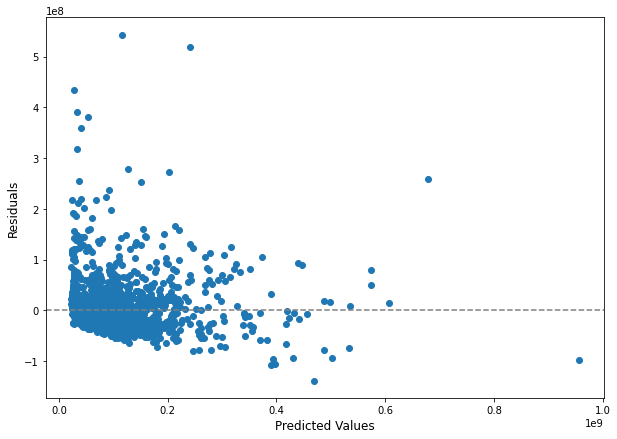

In [209]:
# Plot residuals from statsmodels OLS
plt.figure(figsize=(10, 7))
plt.scatter(fit_OBY.predict(), fit_OBY.resid)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12);

In [268]:
# Define Train-Test-Split function:
def split_val(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    m = LinearRegression()
    m.fit(x_train,y_train)
    return m.score(x_train,y_train),(m.score(x_test,y_test))

In [280]:
def k_fold(x,y,n):
    """
    perform n training and testing runs,
    print R2 for each, and print the average across n runs
    """
    train_sum=0
    test_sum=0
    i=0
    for _ in range(n):
        train, test = split_val(x,y)
        train_sum+=train
        test_sum+=test
        i+=1
        print('run',i, '\t',train, test)
    print('mean:','\t', train_sum/n, test_sum/n)

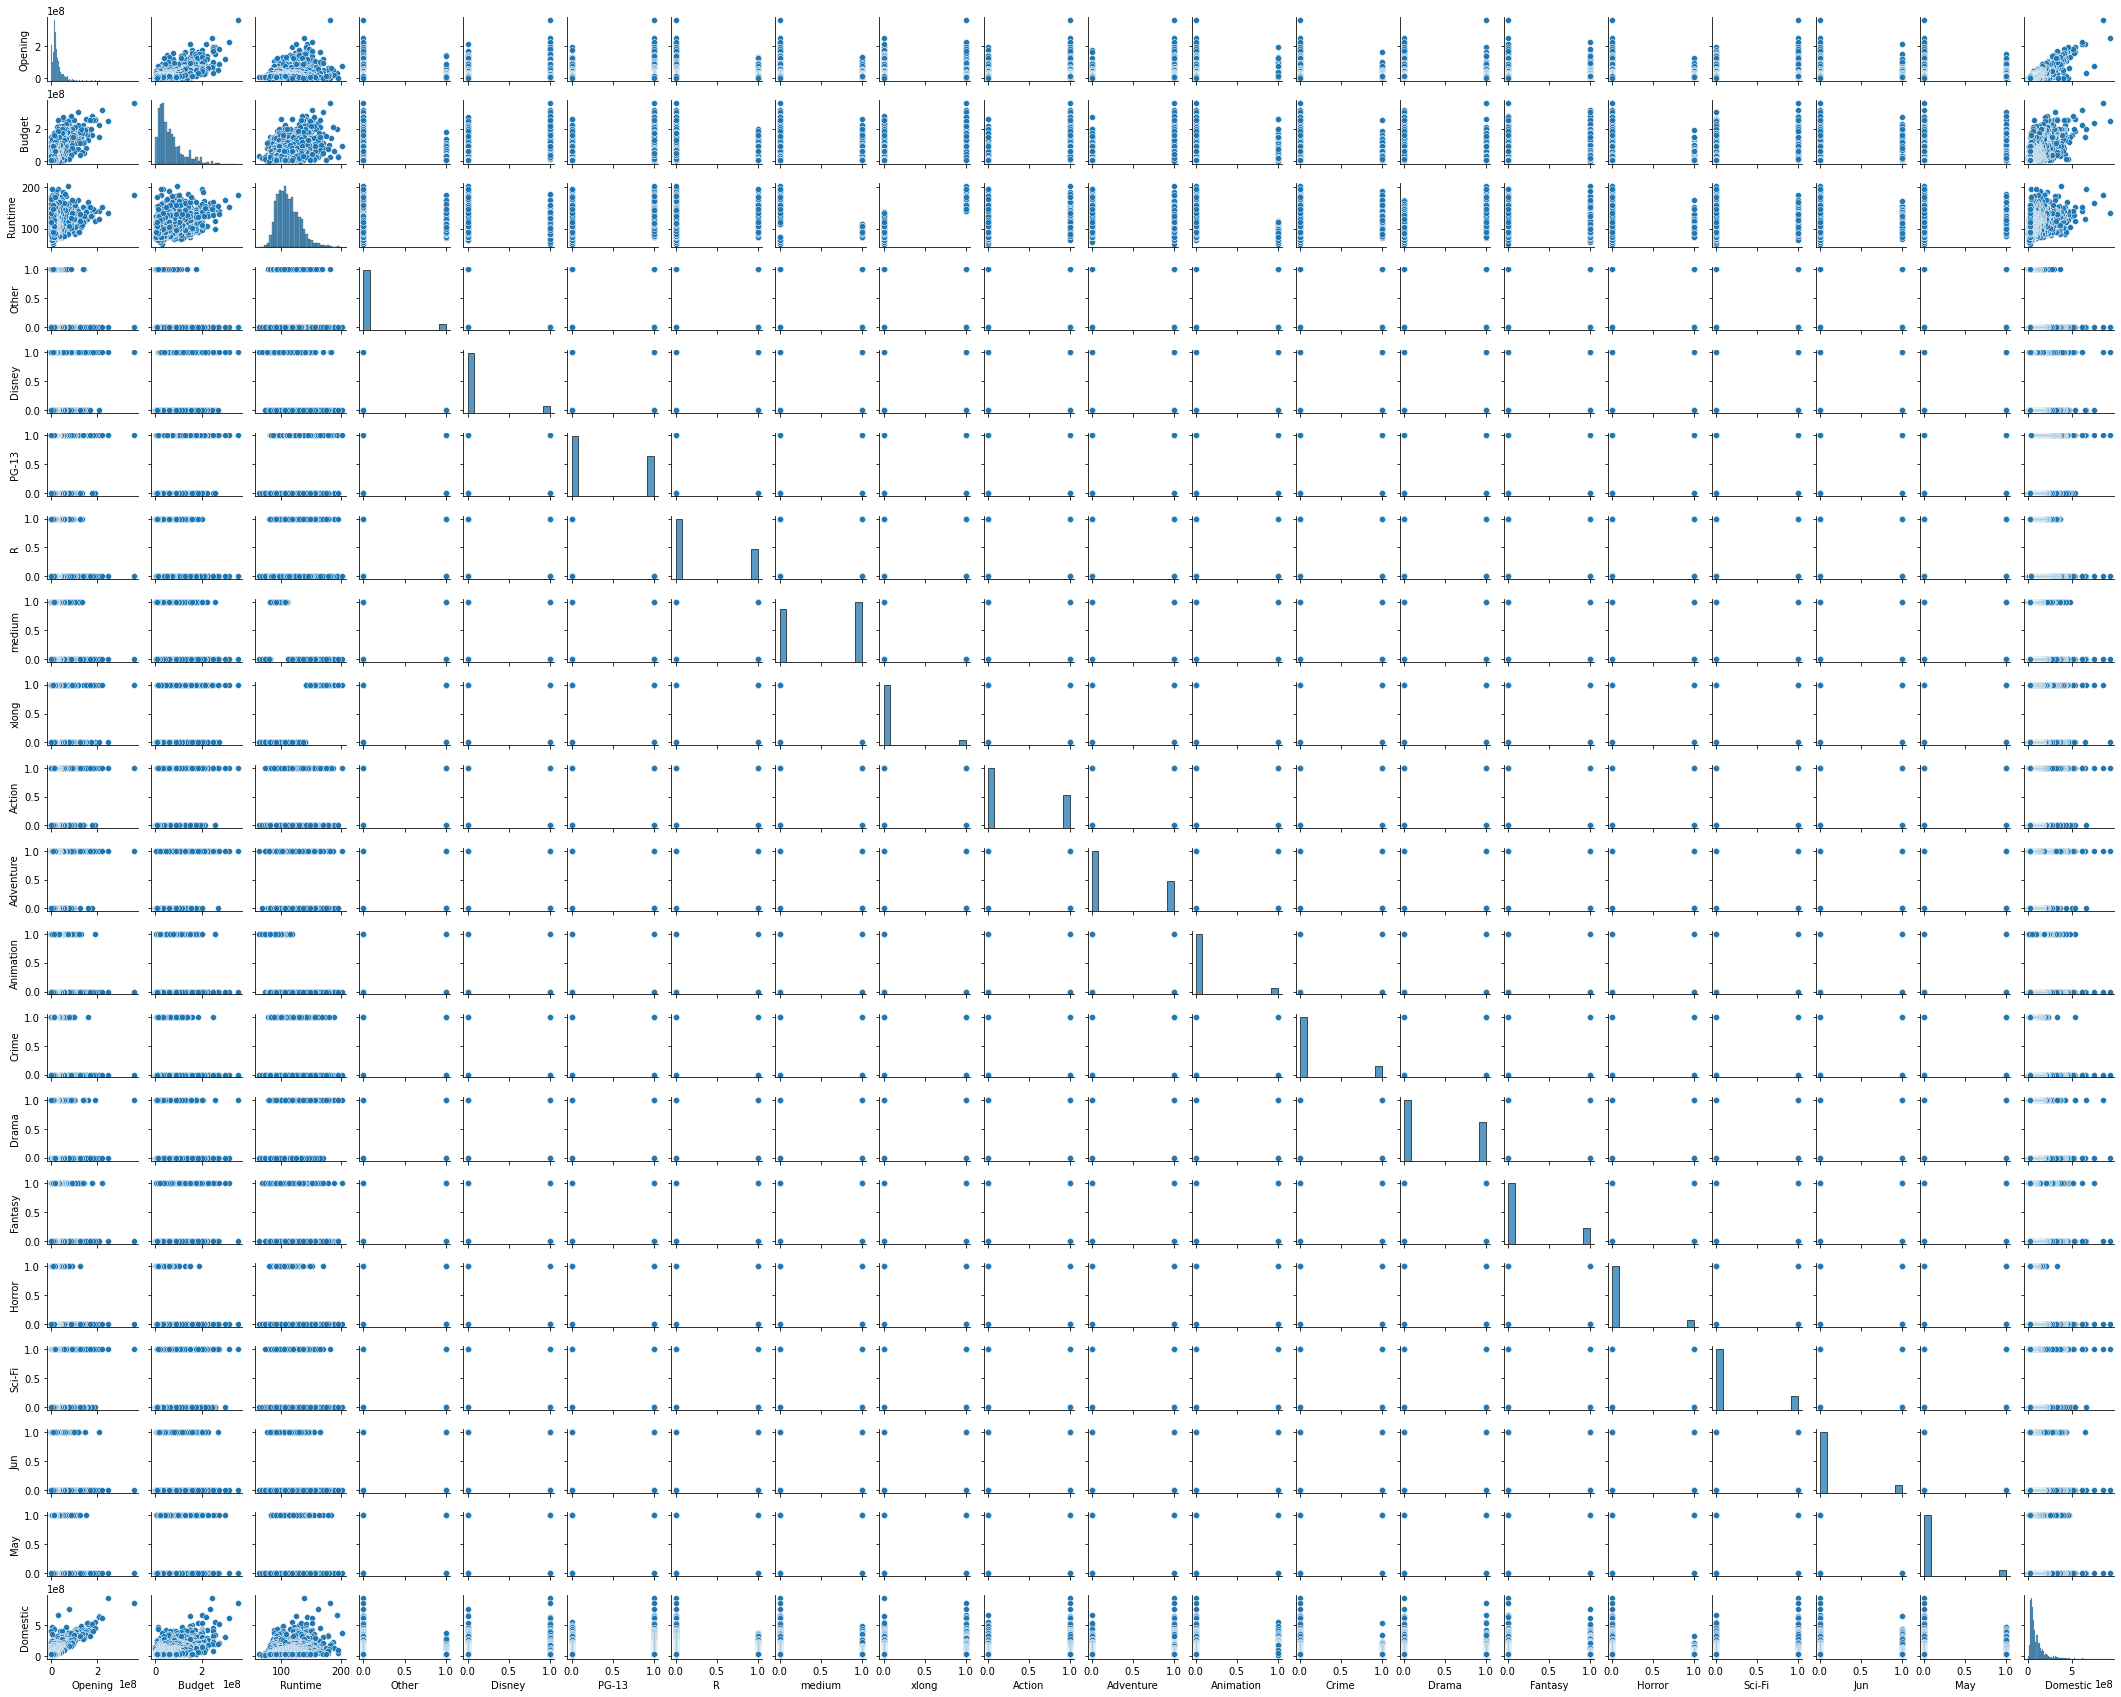

In [147]:
df = X_10
df['Domestic'] = y
sns.pairplot(X_10, height=1.2, aspect=1.25);

In [ ]:
# create test set
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=9)

# Select features with >0.2 correlation with Domestic earnings

In [242]:
# Find the features that are moderately correlated with earnings
movies_corr = movies_df.corr()
mask = ((movies_corr['Domestic'] >= 0.2) | (movies_corr['Domestic'] <= -0.2))
top_feat = movies_corr[mask]['Domestic'].reset_index()
features = list(top_feat['index'])
features.remove('Domestic')
features

['Opening',
 'Budget',
 'Runtime',
 'Walt Disney Studios Motion Pictures',
 'medium',
 'xlong',
 'Action',
 'Adventure',
 'Sci-Fi']

### linear regression

In [243]:
lr_cur = LinearRegression()
X_20 = movies_df[features]
y = movies_df['Domestic']
lr_cur.fit(X_20,y)
lr_cur.score(X_20,y)

0.7159509478737274

### statsmodels linear regresssion

In [244]:
sm_20 = sm.OLS(y, sm.add_constant(X_20))
fit_20 = sm_20.fit()
fit_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Domestic   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     539.1
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:47:50   Log-Likelihood:                -36956.
No. Observations:                1935   AIC:                         7.393e+04
Df Residuals:                    1925   BIC:                         7.399e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                               -4.836e+07   1.41e+07     -3.434      0.001    -7.6e+07   -2.07e+07
Opening                                 2.5246      0.051     49.409      0.000       2.424       2.625
Budget                                 -0.0161      0.032     -0.499      0.618      -0.079       0.047
Runtime                              6.851e+05   1.17e+05      5.880      0.000    4.57e+05    9.14e+05
Walt Disney Studios Motion Pictures  1.795e+07    3.7e+06      4.855      0.000    1.07e+07    2.52e+07
medium                               3.262e+06   3.51e+06      0.930      0.353   -3.62e+06    1.01e+07
xlong                                3.557e+06   5.79e+06      0.614      0.539   -7.81e+06    1.49e+07
Action                              -1.041e+07   2.64e+06     -3.934      0.000   -1.56e+07   -5.22e+06
Adventure                             1.43e+07   2.84e+06      5.031      0.000    8.73e+06    1.99e+07
Sci-Fi                              -2.878e+06   3.17e+06     -0.907      0.365    -9.1e+06    3.35e+06
==============================================================================
Omnibus:                     1602.255   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55342.564
Skew:                           3.692   Prob(JB):                         0.00
Kurtosis:                      28.137   Cond. No.                     1.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### cross-validation of linear model

In [282]:
k_fold(X_20,y,5)

run 1 	 0.7322744912599 0.6557672051825102
run 2 	 0.7129464820829052 0.7214453461561939
run 3 	 0.6956327299291489 0.8140710914544834
run 4 	 0.7041337014403797 0.7403565194925303
run 5 	 0.7258281343632456 0.6634093130223164
mean: 	 0.7141631078151158 0.7190098950616068


### polynomial regression

In [165]:
p = PolynomialFeatures()
X_20_poly = p.fit_transform(X_20)

lr_poly = LinearRegression()
lr_poly.fit(X_20_poly, y)
lr_poly.score(X_20_poly, y)

0.7300677483457598

### cross-validation of polynomial model

In [281]:
k_fold(X_20_poly,y,5)

run 1 	 0.7392041410598104 0.6660220938407527
run 2 	 0.6928203766770411 0.6867510789032358
run 3 	 0.7282348545373107 0.7105556095642647
run 4 	 0.722489204300774 0.7527850923859327
run 5 	 0.6843431924051027 0.7936229600169209
mean: 	 0.7134183537960077 0.7219473669422214


## Select features with >0.1 correlation with Domestic earnings

In [ ]:
# Find the features that are moderately correlated with earnings
movies_corr = movies_df.corr()
mask = ((movies_corr['Domestic'] >= 0.1) | (movies_corr['Domestic'] <= -0.1))
top_feat = movies_corr[mask]['Domestic'].reset_index()
features = list(top_feat['index'])
features.remove('Domestic')
features

### linear-regression

In [230]:
# Create a simple linear regression:
lr_cur = LinearRegression()

# Choose Opening and Budget as features
X_10 = movies_df[features]

# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_cur.fit(X_10,y)

# Score
lr_cur.score(X_10,y)

0.7333832503263402

### statsmodels linear regression

In [239]:
sm_10 = sm.OLS(y, sm.add_constant(X_10))
fit_10 = sm_10.fit()
fit_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Domestic   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     277.2
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:12:35   Log-Likelihood:                -36895.
No. Observations:                1935   AIC:                         7.383e+04
Df Residuals:                    1915   BIC:                         7.394e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                               -7.034e+07   1.48e+07     -4.754      0.000   -9.94e+07   -4.13e+07
Opening                                 2.5562      0.051     50.346      0.000       2.457       2.656
Budget                                 -0.1051      0.034     -3.137      0.002      -0.171      -0.039
Runtime                              9.914e+05   1.25e+05      7.930      0.000    7.46e+05    1.24e+06
Other                                1.488e+06   3.74e+06      0.398      0.691   -5.85e+06    8.83e+06
Walt Disney Studios Motion Pictures   1.32e+07   3.72e+06      3.551      0.000    5.91e+06    2.05e+07
PG-13                               -5.633e+06   3.42e+06     -1.645      0.100   -1.23e+07    1.08e+06
R                                   -1.085e+07   3.75e+06     -2.896      0.004   -1.82e+07    -3.5e+06
medium                               4.673e+06   3.44e+06      1.360      0.174   -2.07e+06    1.14e+07
xlong                               -1.395e+05   5.73e+06     -0.024      0.981   -1.14e+07    1.11e+07
Action                              -4.896e+06    2.8e+06     -1.749      0.080   -1.04e+07    5.94e+05
Adventure                             1.12e+06   3.13e+06      0.357      0.721   -5.03e+06    7.27e+06
Animation                            2.474e+07   4.65e+06      5.324      0.000    1.56e+07    3.38e+07
Crime                               -5.055e+06   3.17e+06     -1.595      0.111   -1.13e+07    1.16e+06
Drama                               -5.562e+06   2.68e+06     -2.078      0.038   -1.08e+07   -3.11e+05
Fantasy                              5.015e+06   3.08e+06      1.627      0.104   -1.03e+06    1.11e+07
Horror                              -1.771e+07   3.91e+06     -4.531      0.000   -2.54e+07      -1e+07
Sci-Fi                              -2.125e+06   3.19e+06     -0.667      0.505   -8.38e+06    4.13e+06
Jun                                  1.543e+07   3.48e+06      4.433      0.000     8.6e+06    2.23e+07
May                                  4.698e+06   3.91e+06      1.200      0.230   -2.98e+06    1.24e+07
==============================================================================
Omnibus:                     1611.797   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59092.583
Skew:                           3.702   Prob(JB):                         0.00
Kurtosis:                      29.040   Cond. No.                     1.30e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+09. This might indicate that there are
strong multicollinearity or other n

### cross-validation of linear model

In [278]:
k_fold(X_10,y,5)

1 	 0.7312836622458867 0.7402467672687805
2 	 0.7255230077148608 0.7580651075317844
3 	 0.7287887862070033 0.7527210789471983
4 	 0.7281198445153911 0.7489436217854952
5 	 0.7334879307077682 0.7245046817446723
average: 	 0.7294406462781821 0.7448962514555861


### polynomial regression

In [ ]:
p = PolynomialFeatures()
X_10_poly = p.fit_transform(X_10)

lr_poly = LinearRegression()
lr_poly.fit(X_10_poly, y)
lr_poly.score(X_10_poly, y)

### cross-validation of polynomial model

In [ ]:
split_val(X_10_poly,y)

## Select features with >0.05 correlation with Domestic earnings

In [231]:
# Find the features that are moderately correlated with earnings
movies_corr = movies_df.corr()
mask = ((movies_corr['Domestic'] >= 0.05) | (movies_corr['Domestic'] <= -0.05))
top_feat = movies_corr[mask]['Domestic'].reset_index()
features = list(top_feat['index'])
features.remove('Domestic')
features

['Opening',
 'Budget',
 'Runtime',
 'Year',
 'DreamWorks',
 'Focus Features',
 'Fox Searchlight Pictures',
 'Metro-Goldwyn-Mayer (MGM)',
 'Other',
 'Screen Gems',
 'Walt Disney Studios Motion Pictures',
 'PG-13',
 'R',
 'long',
 'medium',
 'short',
 'xlong',
 'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Fantasy',
 'History',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'Aug',
 'Feb',
 'Jan',
 'Jun',
 'May',
 'Oct',
 'Sep']

In [232]:
# Create a simple linear regression:
lr_cur = LinearRegression()

# Choose Opening and Budget as features
X_05 = movies_df[features]

# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_cur.fit(X_05,y)

# Score
lr_cur.score(X_05,y)

0.7572704407532462

### statsmodels linear regression

In [240]:
sm_05 = sm.OLS(y, sm.add_constant(X_05))
fit_05 = sm_05.fit()
fit_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Domestic   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     155.7
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:13:52   Log-Likelihood:                -36804.
No. Observations:                1935   AIC:                         7.369e+04
Df Residuals:                    1896   BIC:                         7.390e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                2.353e+09   2.21e+08     10.648      0.000    1.92e+09    2.79e+09
Opening                                 2.6564      0.050     53.019      0.000       2.558       2.755
Budget                                 -0.0690      0.033     -2.072      0.038      -0.134      -0.004
Runtime                              7.997e+05   1.36e+05      5.861      0.000    5.32e+05    1.07e+06
Year                                -1.495e+06   1.38e+05    -10.854      0.000   -1.77e+06   -1.23e+06
DreamWorks                           9.132e+06   9.05e+06      1.009      0.313   -8.62e+06    2.69e+07
Focus Features                      -3.232e+06   9.37e+06     -0.345      0.730   -2.16e+07    1.51e+07
Fox Searchlight Pictures             2.265e+07   9.54e+06      2.374      0.018    3.94e+06    4.14e+07
Metro-Goldwyn-Mayer (MGM)           -1.318e+07   7.93e+06     -1.662      0.097   -2.87e+07    2.37e+06
Other                                3.076e+06   3.64e+06      0.844      0.399   -4.07e+06    1.02e+07
Screen Gems                         -7.661e+06   7.25e+06     -1.056      0.291   -2.19e+07    6.56e+06
Walt Disney Studios Motion Pictures  8.827e+06   3.65e+06      2.421      0.016    1.68e+06     1.6e+07
PG-13                                4.889e+05   3.37e+06      0.145      0.885   -6.12e+06    7.09e+06
R                                   -5.351e+06   3.68e+06     -1.455      0.146   -1.26e+07    1.86e+06
long                                 5.952e+08   5.57e+07     10.696      0.000    4.86e+08    7.04e+08
medium                               5.977e+08   5.55e+07     10.772      0.000    4.89e+08    7.06e+08
short                                5.658e+08   5.53e+07     10.233      0.000    4.57e+08    6.74e+08
xlong                                5.943e+08   5.58e+07     10.646      0.000    4.85e+08    7.04e+08
Action                              -3.582e+06   2.91e+06     -1.229      0.219    -9.3e+06    2.13e+06
Adventure                            5.702e+05   3.04e+06      0.188      0.851   -5.39e+06    6.53e+06
Animation                            2.593e+07   4.63e+06      5.603      0.000    1.69e+07     3.5e+07
Biography                            7.847e+06   5.15e+06      1.524      0.128   -2.25e+06    1.79e+07
Comedy                                6.93e+05   2.92e+06      0.237      0.812   -5.04e+06    6.42e+06
Crime                               -4.524e+06    3.2e+06     -1.413      0.158   -1.08e+07    1.75e+06
Drama                               -2.464e+06   2.74e+06     -0.900      0.368   -7.84e+06    2.91e+06
Fantasy                              4.529e+06      3e+06      1.510      0.131   -1.35e+06    1.04e+07
History                             -8.036e+06   5.98e+06     -1.34

### cross-validation of linear model

In [233]:
split_val(X_05,y)

(0.752608236738606, 0.7637830589426631)

### polynomial regression

In [234]:
p = PolynomialFeatures()
X_05_poly = p.fit_transform(X_05)

lr_poly = LinearRegression()
lr_poly.fit(X_05_poly, y)
lr_poly.score(X_05_poly, y)

0.789851685001203

### cross-validation of polynomial model

In [235]:
split_val(X_05_poly,y)

(0.3463715335188212, 0.34612388592312804)

## Squaring individual features

In [130]:
# Create a simple linear regression:
lr_exp = LinearRegression()

# Choose Opening and Budget as features
X = pd.DataFrame({'Opening': (movies_df['Opening']),\
                  'Budget': (movies_df['Budget']),\
                  'Disney': (movies_df['Walt Disney Studios Motion Pictures']),\
                  'medium': (movies_df['medium']),\
                  'xlong': (movies_df['xlong']),\
                  'Action': (movies_df['Action']),\
                  'Adventure': (movies_df['Adventure']),\
                  'Sci-Fi': (movies_df['Sci-Fi']),\
                  'Year' : (movies_df['Year']),})

X['Opening_2'] = X['Opening']**2
X['Budget_2'] = X['Budget']**2

# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_exp.fit(X,y)

# Score
lr_exp.score(X,y)

0.7169461417776533

# Domestic ~ All

### sklearn

In [172]:
# Create a simple linear regression:
lr_all = LinearRegression()

# Choose Opening and Budget as features
X_all = movies_df.drop(columns=['Domestic','International','Title'], axis=1)

# Choose Domestic earnings as response variable
y = movies_df['Domestic']

# Fit
lr_all.fit(X_all,y)

# Score
lr_all.score(X_all,y)

0.7714173069380519

In [173]:
split_val(X_all,y)

(0.7657298752078668, 0.7771739065190045)

# Polynomial features on all

In [260]:
p = PolynomialFeatures()
X_05_poly = p.fit_transform(X_05)

lr_poly = LinearRegression()
lr_poly.fit(X_05_poly, y)
lr_poly.score(X_05_poly, y)

0.47029963672645014

In [265]:
# Define Train-Test-Split function:
def poly_split_val(x,y):
    p = PolynomialFeatures()
    poly = p.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(poly, y, test_size=0.2)
    
    lr_poly = LinearRegression()
    lr_poly.fit(x_train, y_train)
    
    return lr_poly.score(x_train,y_train),(lr_poly.score(x_test,y_test))
poly_split_val(X_all,y)

(0.8213305452578636, 0.7382574528082958)

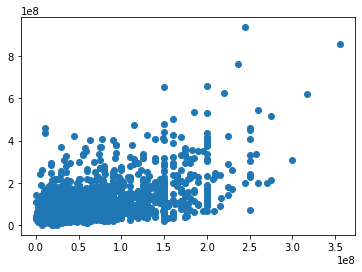

In [264]:
plt.scatter(movies_df['Budget'],movies_df['Domestic'])